In [63]:
#import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import sys
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score, average_precision_score, auc, precision_recall_curve, log_loss
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import precision_recall_curve
from sklearn.pipeline import Pipeline
import joblib
import pandas_profiling as pp
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectKBest
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, f1_score, recall_score
%matplotlib inline
seed = 824
from sklearn import model_selection, metrics
from sklearn.naive_bayes import GaussianNB

In [5]:
# read dataset
df1 = pd.read_csv("Churn_Modelling.csv")
df1.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [6]:
# get info on dataset
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [7]:
df1.shape

(10000, 14)

In [8]:
# drop unwanted columns
df2 = df1.drop(['RowNumber','CustomerId', 'Surname'],axis = 1)

In [9]:
df2.shape

(10000, 11)

In [10]:
profile = pp.ProfileReport(df2)
profile.to_file("project3_output.html")

In [14]:
change_cat = {"Gender":     {"Male": '1', "Female": '2'},
              "Geography": {"France": '1', "Germany": '2', "Spain": '3'}
             }

In [15]:
df2 = df2.replace(change_cat)
df2.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,1,2,42,2,0.00,1,1,1,101348.88,1
1,608,3,2,41,1,83807.86,1,0,1,112542.58,0
2,502,1,2,42,8,159660.80,3,1,0,113931.57,1
3,699,1,2,39,1,0.00,2,0,0,93826.63,0
4,850,3,2,43,2,125510.82,1,1,1,79084.10,0


In [16]:
x_class = df1['Exited'].value_counts()
print(x_class)

0    7963
1    2037
Name: Exited, dtype: int64


The dataset is imbalanced.

In [17]:
print('Customer exited: {0:.2f} %'.format((x_class[1]/len(df1))*100))
print('Customer with open account: {0:.2f} %'.format((x_class[0]/len(df1))*100))

Customer exited: 20.37 %
Customer with open account: 79.63 %


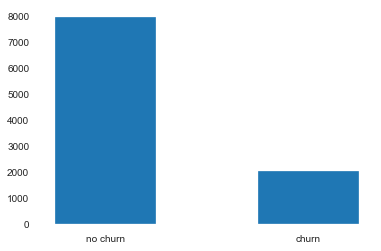

In [18]:
plt.bar(x=['no churn', 'churn'], height = x_class, width = 0.5)
plt.show()

In [19]:
# check for null values
df2.isna().sum() 

CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

# EDA

Text(0.5, 1.0, 'Churn v/s No Churn - Countrywise')

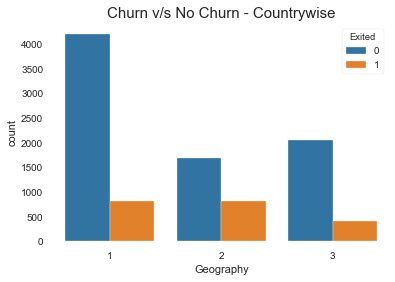

In [21]:
# plot Gerography wise customer churn
sns.countplot(data=df2, x='Geography', hue='Exited')
plt.title('Churn v/s No Churn - Countrywise', fontsize=15)

Text(0.5, 1.0, 'Churn v/s No Churn - Gender')

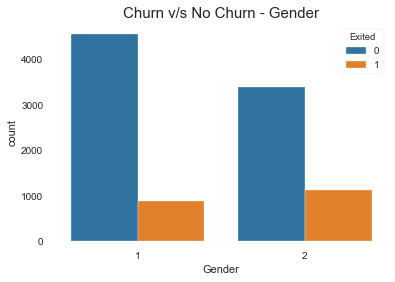

In [22]:
# plot Gender wise customer churn
sns.countplot(data=df2, x='Gender', hue='Exited')
plt.title('Churn v/s No Churn - Gender', fontsize=15)

Text(0.5, 1.0, 'Churn v/s No Churn - NumOfProducts')

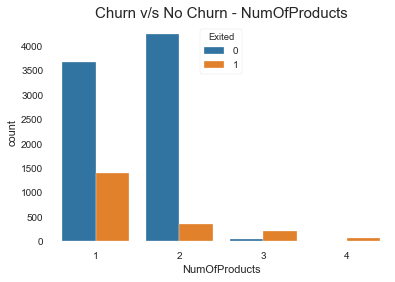

In [23]:
# customer churn v/s number of product
sns.countplot(data=df2, x='NumOfProducts', hue='Exited')
plt.title('Churn v/s No Churn - NumOfProducts', fontsize=15)

Text(0.5, 1.0, 'Churn v/s No Churn - IsActiveMember')

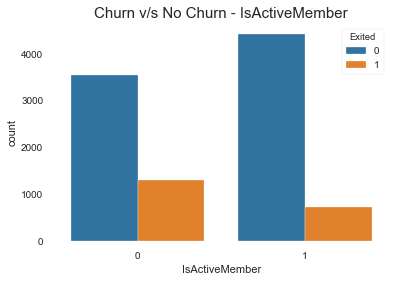

In [29]:
# customer churn v/s IsActiveMember
sns.countplot(data=df2, x='IsActiveMember', hue='Exited')
plt.title('Churn v/s No Churn - IsActiveMember', fontsize=15)

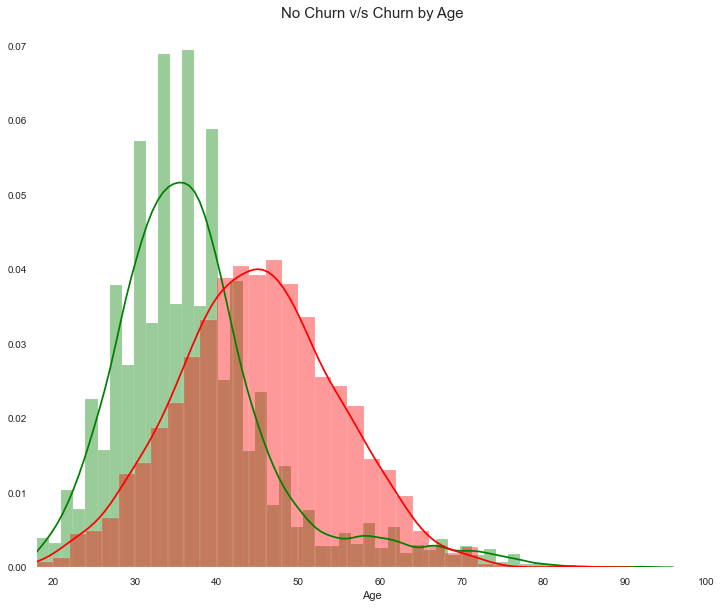

In [25]:
# Churn v/s Age
plt.figure(figsize=(12,10))

sns.distplot(df2[df2['Exited'] == 0]["Age"], color='green') # No Churn - green
sns.distplot(df2[df2['Exited'] == 1]["Age"], color='red') # Churn - Red

plt.title('No Churn v/s Churn by Age', fontsize=15)
plt.xlim([18,100])
plt.show()

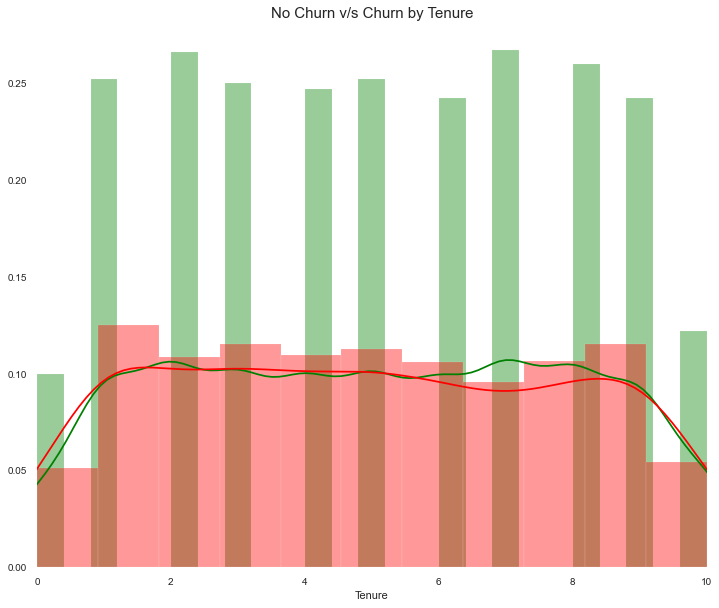

In [28]:
# Churn v/s Tenure
plt.figure(figsize=(12,10))

sns.distplot(df2[df2['Exited'] == 0]["Tenure"], color='green') # No Churn - green
sns.distplot(df2[df2['Exited'] == 1]["Tenure"], color='red') # Churn - Red

plt.title('No Churn v/s Churn by Tenure', fontsize=15)
plt.xlim([0,10])
plt.show()

# Data Cleaning

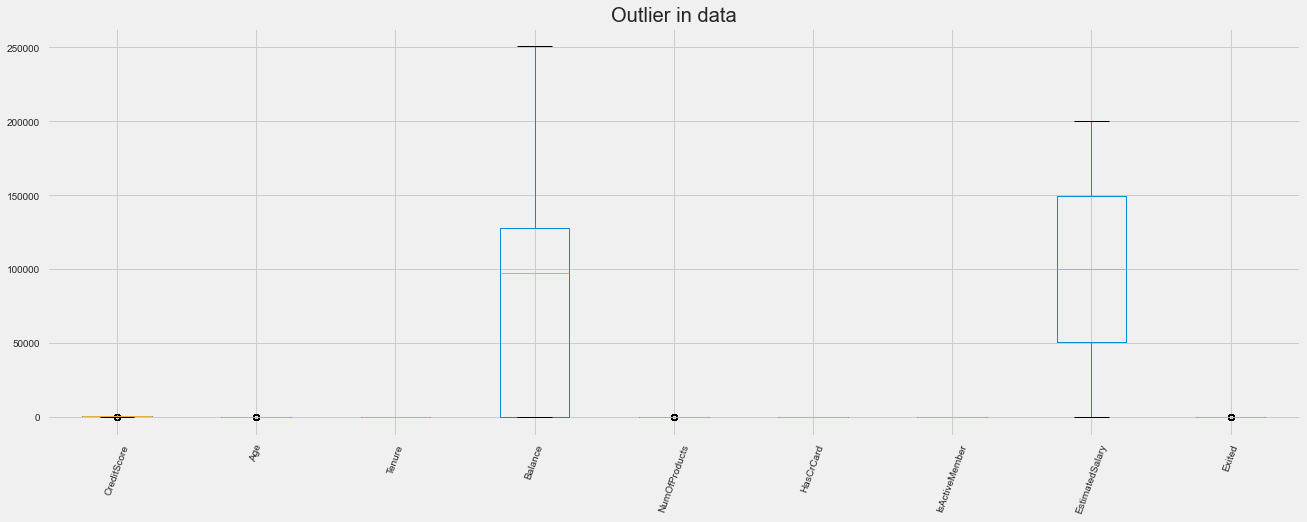

In [30]:
plt.style.use('fivethirtyeight')
outlier= df2.plot(kind='box',figsize=(20,7));
plt.xticks(rotation=70);
plt.title('Outlier in data');

No Outlier in the dataset

# Standardize attributes

In [32]:
# hot encoding
X = df2.drop('Exited', axis=1)  # get only independent variables
y = df2['Exited']  # get output variable

num_cols = X.select_dtypes(include = ['int64', 'float64']).columns.to_list()
cat_cols = X.select_dtypes(include = ['object']).columns.to_list()

In [33]:
def label_encoder(df):
    for i in cat_cols:
        le = LabelEncoder()
        df[i] = le.fit_transform(df[i])
    return df

In [34]:
# robust scaler
rs = RobustScaler()
X[num_cols] = rs.fit_transform(X[num_cols])

# Label encoding
X = label_encoder(X)

X.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,-0.246269,0,1,0.416667,-0.75,-0.761480,0.0,0.0,0.0,0.011739
1,-0.328358,2,1,0.333333,-1.00,-0.104906,0.0,-1.0,0.0,0.125512
2,-1.119403,0,1,0.416667,0.75,0.489346,2.0,0.0,-1.0,0.139630
3,0.350746,0,1,0.166667,-1.00,-0.761480,1.0,-1.0,-1.0,-0.064717
4,1.477612,2,1,0.500000,-0.75,0.221806,0.0,0.0,0.0,-0.214561


In [35]:
# Train Test Split

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size=0.25, random_state=seed)

In [36]:
# over sample the minority class
from imblearn.over_sampling import SMOTE

smote = SMOTE()
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

In [37]:
# Output class count after oversampling
y_class = y_train_balanced.value_counts()
print(y_class)

1    5972
0    5972
Name: Exited, dtype: int64


# Random Forest

In [38]:
params = {'n_estimators': [50, 100, 150, 200],
          'max_depth': [10,20,30,40,50],
          'max_features': ['sqrt', 'log2'],
          'class_weight': ['balanced', None],
           'bootstrap': [True, False]}


rf_grid = GridSearchCV(RandomForestClassifier(random_state=seed),
                       param_grid=params,
                       scoring={'avr': make_scorer(average_precision_score, needs_proba=True),
                                'll': make_scorer(log_loss, greater_is_better=False, needs_proba=True)},
                       n_jobs=-1,
                       cv=5,
                       refit='avr')

In [39]:
rf_grid.fit(X_train_balanced, y_train_balanced)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=824),
             n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'class_weight': ['balanced', None],
                         'max_depth': [10, 20, 30, 40, 50],
                         'max_features': ['sqrt', 'log2'],
                         'n_estimators': [50, 100, 150, 200]},
             refit='avr',
             scoring={'avr': make_scorer(average_precision_score, needs_proba=True),
                      'll': make_scorer(log_loss, greater_is_better=False, needs_proba=True)})

In [40]:
rf_file = 'rf_model3.sav'  # file name to store RF model
joblib.dump(rf_grid, rf_file)  # stores the model

['rf_model3.sav']

In [41]:
rf_grid.best_score_, rf_grid.best_params_

(0.9701940063004777,
 {'bootstrap': False,
  'class_weight': 'balanced',
  'max_depth': 30,
  'max_features': 'sqrt',
  'n_estimators': 200})

In [42]:
from sklearn.calibration import CalibratedClassifierCV, calibration_curve

predictions = rf_grid.predict_proba(X_train_balanced)[:, 1]
binned_true_p, binned_predict_p = calibration_curve(y_train_balanced, predictions, n_bins=10)

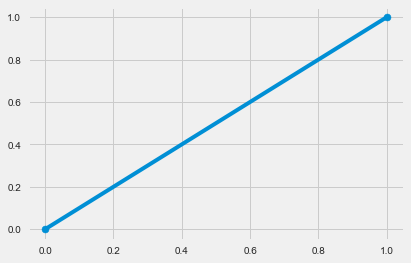

In [43]:
plt.scatter(binned_true_p, binned_predict_p)
m, b = np.polyfit(binned_true_p, binned_predict_p, 1)
plt.plot(binned_true_p, m*binned_true_p + b)
plt.show()

# Naive Bayes

In [64]:
nb_model = GaussianNB()
nb_model.fit(X_train_balanced, y_train_balanced)

GaussianNB()

In [69]:
params = {'var_smoothing': [1e-9, 1e-10]}

nb_grid= GridSearchCV(cv=5, estimator=GaussianNB(),
             n_jobs=-1,
             param_grid=params,
             refit='avr',
             scoring={'avr': make_scorer(average_precision_score, needs_proba=True),
                      'll': make_scorer(log_loss, greater_is_better=False, needs_proba=True)})

In [70]:
nb_grid.fit(X_train_balanced, y_train_balanced)

GridSearchCV(cv=5, estimator=GaussianNB(), n_jobs=-1,
             param_grid={'var_smoothing': [1e-09, 1e-10]}, refit='avr',
             scoring={'avr': make_scorer(average_precision_score, needs_proba=True),
                      'll': make_scorer(log_loss, greater_is_better=False, needs_proba=True)})

In [71]:
nb_file = 'nb_model3.sav'  # file name to store RF model
joblib.dump(rf_grid, rf_file)  # stores the model

['rf_model3.sav']

In [73]:
nb_grid.best_score_, nb_grid.best_params_

(0.8229662772707792, {'var_smoothing': 1e-09})

# Artificial Neural Network

In [74]:
params = [{'solver': ['lbfgs'],
           'max_iter': [100, 200, 300]},
          {'solver': ['sgd'],
           'max_iter': [100, 200, 300],
           'learning_rate_init': [0.001,0.01,1]},
          {'solver': ['adam'],
           'max_iter': [100, 200, 300],
           'learning_rate_init': [0.001,0.01,1]}]

ann_grid = GridSearchCV(MLPClassifier(random_state=seed),
                       param_grid=params,
                       scoring={'avr': make_scorer(average_precision_score, needs_proba=True),
                                'll': make_scorer(log_loss, greater_is_better=False, needs_proba=True)},
                       n_jobs=-1,
                       cv=5,
                       refit='avr')

In [75]:
ann_grid.fit(X_train_balanced, y_train_balanced)
ann_file = 'ann_model3.sav'  # file name to store svc model
joblib.dump(ann_grid, ann_file)  # stores the model

['ann_model3.sav']

In [76]:
ann_grid.best_score_, ann_grid.best_params_

(0.9055841435402096, {'max_iter': 300, 'solver': 'lbfgs'})

# Gradient Boosting

In [83]:
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier

In [85]:

params = {'learning_rate': [0.1, 0.01, 0.001],
          'max_iter': [1000, 2000, 3000],
          'max_leaf_nodes': [6,8,10],
          'validation_fraction': [0.1,0.2,0.3],
           'n_iter_no_change': [10, 15, 20]}

gb_grid = GridSearchCV(HistGradientBoostingClassifier(random_state=seed),
                       param_grid=params,
                       scoring={'avr': make_scorer(average_precision_score, needs_proba=True),
                                'll': make_scorer(log_loss, greater_is_better=False, needs_proba=True)},
                       n_jobs=-1,
                       cv=5,
                       refit='avr')

In [86]:
gb_grid.fit(X_train_balanced, y_train_balanced)
gb_file = 'gb_model3.sav'  # file name to store svc model
joblib.dump(gb_grid, gb_file)  # stores the model

['gb_model3.sav']

In [87]:
gb_grid.best_score_, gb_grid.best_params_

(0.9642800779072725,
 {'learning_rate': 0.1,
  'max_iter': 3000,
  'max_leaf_nodes': 10,
  'n_iter_no_change': 10,
  'validation_fraction': 0.1})

# Test

In [88]:
# get f1 matrix after predicting the test set
y_pred = gb_grid.predict(X_test)
from sklearn.metrics import classification_report
target_names = ['no churn', 'churn']
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

    no churn       0.90      0.92      0.91      1991
       churn       0.65      0.59      0.62       509

    accuracy                           0.85      2500
   macro avg       0.78      0.76      0.77      2500
weighted avg       0.85      0.85      0.85      2500



In [89]:
# get f1 matrix after predicting the test set
y_pred = nb_grid.predict(X_test)
from sklearn.metrics import classification_report
target_names = ['no churn', 'churn']
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

    no churn       0.91      0.74      0.82      1991
       churn       0.41      0.71      0.52       509

    accuracy                           0.74      2500
   macro avg       0.66      0.73      0.67      2500
weighted avg       0.81      0.74      0.76      2500



In [90]:
# get f1 matrix after predicting the test set
y_pred = ann_grid.predict(X_test)
from sklearn.metrics import classification_report
target_names = ['no churn', 'churn']
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

    no churn       0.90      0.83      0.86      1991
       churn       0.49      0.63      0.55       509

    accuracy                           0.79      2500
   macro avg       0.69      0.73      0.71      2500
weighted avg       0.81      0.79      0.80      2500



In [91]:
# get f1 matrix after predicting the test set
y_pred = rf_grid.predict(X_test)
from sklearn.metrics import classification_report
target_names = ['no churn', 'churn']
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

    no churn       0.90      0.92      0.91      1991
       churn       0.65      0.59      0.62       509

    accuracy                           0.85      2500
   macro avg       0.77      0.76      0.76      2500
weighted avg       0.85      0.85      0.85      2500



In [92]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)

array([[1827,  164],
       [ 207,  302]])

In [93]:
print(accuracy_score(y_test, y_pred))
print(precision_score(y_test, y_pred))
print(recall_score(y_test, y_pred))
print(f1_score(y_test, y_pred))

0.8516
0.648068669527897
0.593320235756385
0.6194871794871796


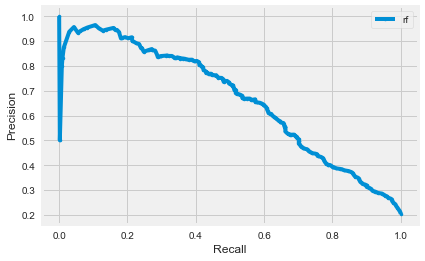

In [94]:
# plot precision recall curve
# predict probabilities
yhat = rf_grid.predict_proba(X_test)
# retrieve just the probabilities for the positive class
pos_probs = yhat[:, 1]
# calculate model precision-recall curve
precision, recall, _ = precision_recall_curve(y_test, pos_probs)
# plot the model precision-recall curve
plt.plot(recall, precision, marker='.', label='rf')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
# show the plot
plt.show()

# RF is the best model